# Домашнее задание 2: Создание и оптимизация ResNet18

In [4]:
import os
import shutil
import random
from PIL import Image
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

from tqdm import tqdm
import zipfile

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Часть 1: Подготовка данных

 Загрузка данных датасета


In [5]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        zip_path = f'{root_dir}.zip'
        temp_extract = "./_temp_extract"

        if not os.path.exists(root_dir):
          if not os.path.exists(zip_path):
              print(f"Файл {zip_path} не найден.")
          else:
              with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                  zip_ref.extractall(temp_extract)
                  inner_folder = os.path.join(temp_extract, "tiny-imagenet-200")

                  os.makedirs(self.root_dir, exist_ok=True)
                  for item in os.listdir(inner_folder):
                      src = os.path.join(inner_folder, item)
                      dst = os.path.join(self.root_dir, item)
                      if os.path.isdir(src):
                          shutil.copytree(src, dst, dirs_exist_ok=True)
                      else:
                          shutil.copy2(src, dst)
                  shutil.rmtree(temp_extract)
                  print(f"Архив {zip_path} успешно распакован в папку {root_dir}.")

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

class TinyImageNetSubDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "tiny-imagenet-200"

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
test_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Классов: {len(train_dataset.class_names)}")

Архив tiny-imagenet-200.zip успешно распакован в папку tiny-imagenet-200.
Train size: 100000
Test size: 10000
Классов: 200


Разделение выборки на тренировочную и валидационную

In [6]:
all_samples = train_dataset.samples
X = [x for x, y in all_samples]
y = [y for x, y in all_samples]

print(f" Подготовлено {len(X)} образцов с {len(set(y))} классами")

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

train_split_stratified = [all_samples[i] for i in train_idx]
val_split_stratified = [all_samples[i] for i in val_idx]

print(f" Стратифицированное разделение:")
print(f"   Train: {len(train_split_stratified)} образцов")
print(f"   Val: {len(val_split_stratified)} образцов")

 Подготовлено 100000 образцов с 200 классами
 Стратифицированное разделение:
   Train: 80000 образцов
   Val: 20000 образцов


Ограничение датасетов на 10 классов

In [7]:
selected_wnids = ['n02123045', 'n01443537',  'n01629819', 'n02206856',  'n04285008',
                  'n07749582', 'n09246464', 'n03085013', 'n02823428', 'n04008634']
selected_classes = [train_dataset.class_names.index(wnid) for wnid in selected_wnids]


subset_train_samples = [s for s in train_split_stratified if s[1] in selected_classes]
subset_val_samples = [s for s in val_split_stratified if s[1] in selected_classes]
subset_test_samples = [s for s in test_dataset.samples if s[1] in selected_classes]

print(f"Используем {len(subset_train_samples)} train, {len(subset_val_samples)} val и {len(subset_test_samples)} test изображений "
      f"из {len(selected_classes)} классов")

class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

subset_train_samples = remap_samples(subset_train_samples)
subset_val_samples = remap_samples(subset_val_samples)
subset_test_samples = remap_samples(subset_test_samples)



train_subset_dataset = TinyImageNetSubDataset(subset_train_samples, transform=train_transform)
val_subset_dataset = TinyImageNetSubDataset(subset_val_samples, transform=val_transform)
test_subset_dataset = TinyImageNetSubDataset(subset_test_samples, transform=val_transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_subset_dataset, batch_size=len(test_subset_dataset), shuffle=False)

Используем 4000 train, 1000 val и 500 test изображений из 10 классов


In [8]:
with open(os.path.join(root, 'words.txt'), 'r') as f:
    wnid_to_word = {}
    for line in f:
        wnid, word = line.strip().split('\t', 1)
        wnid_to_word[wnid] = word

class_names_human = [wnid_to_word[wnid].split(",")[0] for wnid in selected_wnids]

## Часть 2: Базовая архитектура ResNet18

### 2.1. Реализация Basic Block

In [9]:
class BasicBlock(nn.Module):
    """
    Базовый блок ResNet с residual connection

    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, activation="relu"):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        match activation:
            case "relu":
                self.activation = nn.ReLU(inplace=True)
            case "leakyrelu":
                self.activation = nn.LeakyReLU(inplace=True)
            case "elu":
                self.activation = nn.ELU(inplace=True)
            case "gelu":
                self.activation = nn.GELU()
            case _:
                self.activation = nn.ReLU(inplace=True)

        self.downsample = nn.Identity()
        if (in_channels != out_channels) or (downsample != None):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        x_in = self.downsample(x)
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += x_in
        out = self.activation(out)
        return out

### 2.2. Реализация ResNet18

In [10]:
class SimpleResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, 2)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, 2)
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.basic_block_4_0 = BasicBlock(256, 512, 2)
        self.basic_block_4_1 = BasicBlock(512, 512)

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))
        x = self.basic_block_4_1(self.basic_block_4_0(x))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [11]:
model = SimpleResNet18()
test_input = torch.randn(1, 3, 64, 64)
output = model(test_input)
print(output.shape)

torch.Size([1, 10])


In [12]:
total_params = sum(p.numel() for p in model.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 11,173,962


### 2.3. Ограничения для базовой модели

In [13]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, 2)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, 2)
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.basic_block_4_0 = BasicBlock(256, 256)
        self.basic_block_4_1 = BasicBlock(256, 200)


        self.fc = nn.Linear(200, num_classes)

    def forward(self, x):
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))
        x = self.basic_block_4_1(self.basic_block_4_0(x))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [14]:
model_base = BaseModel()
test_input = torch.randn(1, 3, 64, 64)
output = model_base(test_input)
print(output.shape)

torch.Size([1, 10])


In [15]:
total_params = sum(p.numel() for p in model_base.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 4,794,314


### 2.4. Скрипт обучения


In [16]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Функция для одной эпохи обучения

    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)

    Returns:
        train_loss: средняя потеря за эпох
        train_acc: средняя точность за эпох
    """
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training")

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        predicted = model(data)

        loss = criterion(predicted, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        total += target.size(0)
        correct += (predicted.argmax(dim=1) == target).sum().item()

    return running_loss / len(train_loader), 100 * correct / total

In [17]:
def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации модели

    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)

    Returns:
        val_loss: средняя потеря на валидации
        val_acc: средняя точность на валидации
    """
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device)
          predicted = model(data)

          loss = criterion(predicted, target)
          running_loss += loss.item()

          total += target.size(0)
          correct += (predicted.argmax(dim=1) == target).sum().item()

    return running_loss / len(val_loader), 100 * correct / total

In [18]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, model_path='best_model.pth'):
    """
    Основная функция для обучения модели

    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
        num_epochs: количество эпох

    Returns:
        history: словарь с историей обучения
    """
    print(f"Обучение на {num_epochs} эпох...")

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    model = model.to(device)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f" Эпоха {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f" Сохранена лучшая модель с точностью {val_acc:.2f}%")


    return history



In [19]:
optimizer = torch.optim.Adam(model_base.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_base = train_model(
    model=model_base,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_base.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.36it/s]


 Train Loss: 1.8255, Train Acc: 33.74%
 Val Loss: 2.0504, Val Acc: 31.04%
 Сохранена лучшая модель с точностью 31.04%
 Эпоха 2/25


Validation: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


 Train Loss: 1.5040, Train Acc: 47.43%
 Val Loss: 1.9157, Val Acc: 42.08%
 Сохранена лучшая модель с точностью 42.08%
 Эпоха 3/25


Validation: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


 Train Loss: 1.3194, Train Acc: 55.37%
 Val Loss: 1.6329, Val Acc: 48.23%
 Сохранена лучшая модель с точностью 48.23%
 Эпоха 4/25


Validation: 100%|██████████| 15/15 [00:01<00:00,  7.58it/s]


 Train Loss: 1.1927, Train Acc: 60.03%
 Val Loss: 1.3229, Val Acc: 53.12%
 Сохранена лучшая модель с точностью 53.12%
 Эпоха 5/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.40it/s]


 Train Loss: 1.1182, Train Acc: 62.00%
 Val Loss: 1.3576, Val Acc: 56.25%
 Сохранена лучшая модель с точностью 56.25%
 Эпоха 6/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.31it/s]


 Train Loss: 1.0437, Train Acc: 65.17%
 Val Loss: 1.3599, Val Acc: 54.17%
 Эпоха 7/25


Validation: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


 Train Loss: 0.9970, Train Acc: 66.20%
 Val Loss: 1.2827, Val Acc: 60.10%
 Сохранена лучшая модель с точностью 60.10%
 Эпоха 8/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.86it/s]


 Train Loss: 0.9012, Train Acc: 69.86%
 Val Loss: 2.0035, Val Acc: 47.60%
 Эпоха 9/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.28it/s]


 Train Loss: 0.8666, Train Acc: 71.32%
 Val Loss: 1.1591, Val Acc: 64.90%
 Сохранена лучшая модель с точностью 64.90%
 Эпоха 10/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


 Train Loss: 0.8011, Train Acc: 73.77%
 Val Loss: 1.1080, Val Acc: 64.48%
 Эпоха 11/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.27it/s]


 Train Loss: 0.7480, Train Acc: 75.98%
 Val Loss: 1.2049, Val Acc: 64.58%
 Эпоха 12/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.20it/s]


 Train Loss: 0.7293, Train Acc: 75.38%
 Val Loss: 1.0797, Val Acc: 65.31%
 Сохранена лучшая модель с точностью 65.31%
 Эпоха 13/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.15it/s]


 Train Loss: 0.6726, Train Acc: 77.34%
 Val Loss: 1.0019, Val Acc: 69.69%
 Сохранена лучшая модель с точностью 69.69%
 Эпоха 14/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.65it/s]


 Train Loss: 0.6217, Train Acc: 78.98%
 Val Loss: 1.1563, Val Acc: 65.52%
 Эпоха 15/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.33it/s]


 Train Loss: 0.6062, Train Acc: 79.33%
 Val Loss: 1.1301, Val Acc: 66.35%
 Эпоха 16/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.15it/s]


 Train Loss: 0.5764, Train Acc: 81.20%
 Val Loss: 0.9453, Val Acc: 68.65%
 Эпоха 17/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.00it/s]


 Train Loss: 0.5536, Train Acc: 82.03%
 Val Loss: 1.0334, Val Acc: 66.15%
 Эпоха 18/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.18it/s]


 Train Loss: 0.4934, Train Acc: 84.17%
 Val Loss: 1.2891, Val Acc: 62.08%
 Эпоха 19/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.79it/s]


 Train Loss: 0.4655, Train Acc: 83.90%
 Val Loss: 0.9982, Val Acc: 67.08%
 Эпоха 20/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.14it/s]


 Train Loss: 0.4490, Train Acc: 85.36%
 Val Loss: 0.8785, Val Acc: 74.17%
 Сохранена лучшая модель с точностью 74.17%
 Эпоха 21/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.22it/s]


 Train Loss: 0.3669, Train Acc: 88.16%
 Val Loss: 0.7673, Val Acc: 76.88%
 Сохранена лучшая модель с точностью 76.88%
 Эпоха 22/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.43it/s]


 Train Loss: 0.3718, Train Acc: 87.20%
 Val Loss: 0.9068, Val Acc: 73.75%
 Эпоха 23/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.35it/s]


 Train Loss: 0.3277, Train Acc: 89.24%
 Val Loss: 1.1065, Val Acc: 68.85%
 Эпоха 24/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.10it/s]


 Train Loss: 0.3071, Train Acc: 89.99%
 Val Loss: 0.8181, Val Acc: 76.46%
 Эпоха 25/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.71it/s]

 Train Loss: 0.2590, Train Acc: 91.15%
 Val Loss: 1.2174, Val Acc: 68.23%


### 2.5: Визуализация базовых результатов

In [20]:
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax1.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax1.plot(np.arange(1, len(history['val_acc'])-1, 1), np.convolve(history['val_acc'], np.ones(3)/3, mode='valid'), label='Smooth val acc', color='red', alpha=0.3 )
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_loss'], label='Train Loss', color='blue')
    ax2.plot(history['val_loss'], label='Validation Loss', color='red')
    ax2.plot(np.arange(1, len(history['val_loss'])-1, 1), np.convolve(history['val_loss'], np.ones(3)/3, mode='valid'), label='Smooth val loss', color='red', alpha=0.3 )
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)


    plt.tight_layout()
    plt.show()

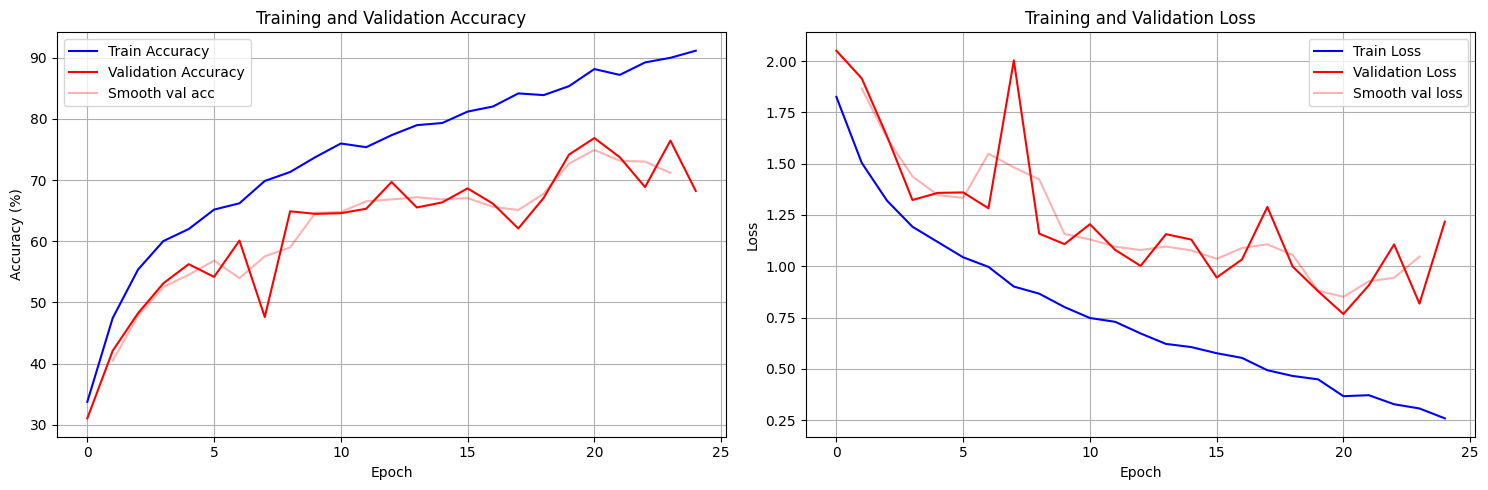

In [21]:
plot_training_history(history_base)

In [22]:
total_params = sum(p.numel() for p in model_base.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 4,794,314


In [23]:
print(model_base)

BaseModel(
  (basic_block_1_0): BasicBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (basic_block_1_1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=

## Часть 3: Поэтапная оптимизация модели

### 3.1: Оптимизация количества каналов

In [24]:
class Model31A(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 32)
        self.basic_block_1_1 = BasicBlock(32, 32)

        self.basic_block_2_0 = BasicBlock(32, 64, 2)
        self.basic_block_2_1 = BasicBlock(64, 64)

        self.basic_block_3_0 = BasicBlock(64, 128, 2)
        self.basic_block_3_1 = BasicBlock(128, 128)

        self.basic_block_4_0 = BasicBlock(128, 256, 2)
        self.basic_block_4_1 = BasicBlock(256, 256)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))
        x = self.basic_block_4_1(self.basic_block_4_0(x))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [25]:
model_3_1_A = Model31A()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_1_A(test_input)
print(output.shape)

torch.Size([1, 10])


In [26]:
total_params = sum(p.numel() for p in model_3_1_A.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 2,788,490


In [27]:
optimizer = torch.optim.Adam(model_3_1_A.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_1_A = train_model(
    model=model_3_1_A,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_31A.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.89it/s]


 Train Loss: 1.8272, Train Acc: 36.27%
 Val Loss: 1.9943, Val Acc: 35.21%
 Сохранена лучшая модель с точностью 35.21%
 Эпоха 2/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.99it/s]


 Train Loss: 1.3844, Train Acc: 51.86%
 Val Loss: 1.4200, Val Acc: 51.56%
 Сохранена лучшая модель с точностью 51.56%
 Эпоха 3/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.27it/s]


 Train Loss: 1.2140, Train Acc: 59.02%
 Val Loss: 1.3601, Val Acc: 55.00%
 Сохранена лучшая модель с точностью 55.00%
 Эпоха 4/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


 Train Loss: 1.0718, Train Acc: 64.09%
 Val Loss: 1.1669, Val Acc: 60.31%
 Сохранена лучшая модель с точностью 60.31%
 Эпоха 5/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.23it/s]


 Train Loss: 0.9828, Train Acc: 67.44%
 Val Loss: 1.1740, Val Acc: 61.25%
 Сохранена лучшая модель с точностью 61.25%
 Эпоха 6/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.39it/s]


 Train Loss: 0.8741, Train Acc: 70.82%
 Val Loss: 1.1276, Val Acc: 64.90%
 Сохранена лучшая модель с точностью 64.90%
 Эпоха 7/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.35it/s]


 Train Loss: 0.8050, Train Acc: 73.16%
 Val Loss: 1.2263, Val Acc: 59.69%
 Эпоха 8/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


 Train Loss: 0.7380, Train Acc: 75.15%
 Val Loss: 1.0520, Val Acc: 67.40%
 Сохранена лучшая модель с точностью 67.40%
 Эпоха 9/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.00it/s]


 Train Loss: 0.6879, Train Acc: 76.56%
 Val Loss: 1.2085, Val Acc: 62.71%
 Эпоха 10/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.36it/s]


 Train Loss: 0.6077, Train Acc: 78.86%
 Val Loss: 0.9159, Val Acc: 68.85%
 Сохранена лучшая модель с точностью 68.85%
 Эпоха 11/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.23it/s]


 Train Loss: 0.5295, Train Acc: 82.71%
 Val Loss: 0.9234, Val Acc: 71.67%
 Сохранена лучшая модель с точностью 71.67%
 Эпоха 12/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.07it/s]


 Train Loss: 0.4758, Train Acc: 83.59%
 Val Loss: 0.8995, Val Acc: 70.52%
 Эпоха 13/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.10it/s]


 Train Loss: 0.4059, Train Acc: 86.27%
 Val Loss: 1.0146, Val Acc: 69.06%
 Эпоха 14/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.88it/s]


 Train Loss: 0.3817, Train Acc: 87.22%
 Val Loss: 0.9285, Val Acc: 69.58%
 Эпоха 15/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 17.50it/s]


 Train Loss: 0.3136, Train Acc: 89.64%
 Val Loss: 1.0115, Val Acc: 69.38%
 Эпоха 16/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.32it/s]


 Train Loss: 0.2524, Train Acc: 91.96%
 Val Loss: 0.8703, Val Acc: 74.69%
 Сохранена лучшая модель с точностью 74.69%
 Эпоха 17/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.72it/s]


 Train Loss: 0.2096, Train Acc: 93.09%
 Val Loss: 0.9625, Val Acc: 72.29%
 Эпоха 18/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.30it/s]


 Train Loss: 0.1525, Train Acc: 95.19%
 Val Loss: 1.3420, Val Acc: 69.27%
 Эпоха 19/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.77it/s]


 Train Loss: 0.1245, Train Acc: 96.32%
 Val Loss: 1.3783, Val Acc: 67.08%
 Эпоха 20/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.94it/s]


 Train Loss: 0.1452, Train Acc: 95.56%
 Val Loss: 1.1034, Val Acc: 71.46%
 Эпоха 21/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.25it/s]


 Train Loss: 0.0737, Train Acc: 97.93%
 Val Loss: 1.1464, Val Acc: 71.56%
 Эпоха 22/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


 Train Loss: 0.0558, Train Acc: 98.61%
 Val Loss: 1.1890, Val Acc: 71.67%
 Эпоха 23/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.87it/s]


 Train Loss: 0.0567, Train Acc: 98.64%
 Val Loss: 1.0176, Val Acc: 73.33%
 Эпоха 24/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.00it/s]


 Train Loss: 0.0566, Train Acc: 98.61%
 Val Loss: 1.4474, Val Acc: 67.60%
 Эпоха 25/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.33it/s]

 Train Loss: 0.0510, Train Acc: 98.61%
 Val Loss: 1.0081, Val Acc: 74.38%


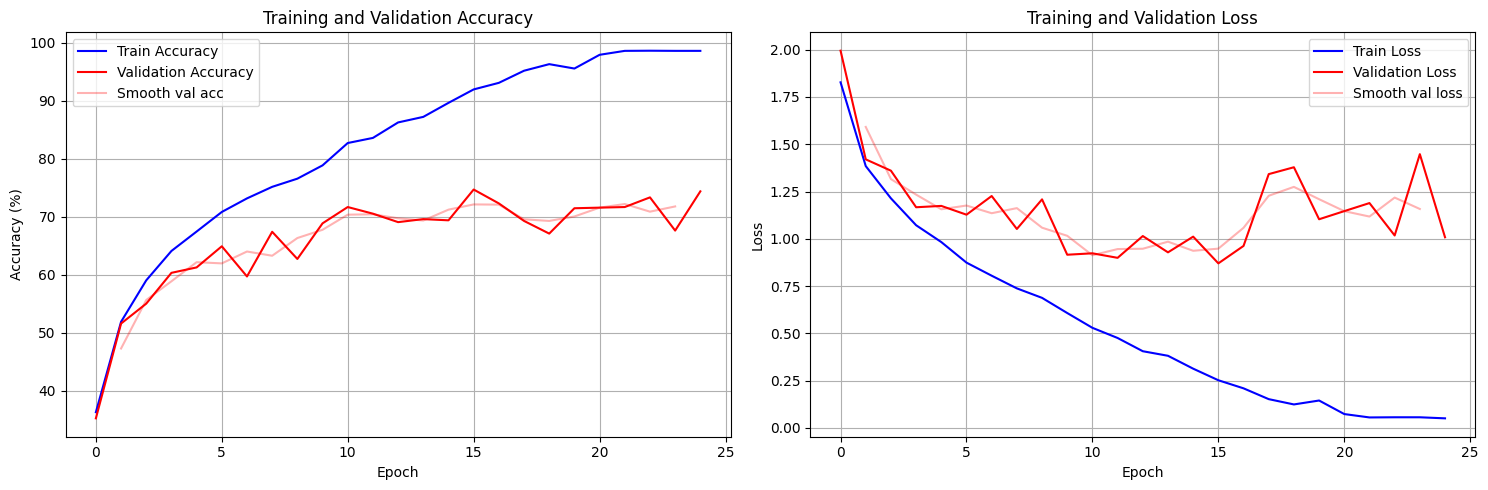

In [28]:
plot_training_history(history_3_1_A)

In [29]:
class Model31B(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, 2)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, 2)
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [30]:
model_3_1_B = Model31B()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_1_B(test_input)
print(output.shape)

torch.Size([1, 10])


In [31]:
total_params = sum(p.numel() for p in model_3_1_B.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 2,741,002


In [32]:
optimizer = torch.optim.Adam(model_3_1_B.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_1_B = train_model(
    model=model_3_1_B,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_31B.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.54it/s]


 Train Loss: 1.7868, Train Acc: 37.37%
 Val Loss: 1.8509, Val Acc: 39.06%
 Сохранена лучшая модель с точностью 39.06%
 Эпоха 2/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.68it/s]


 Train Loss: 1.4978, Train Acc: 48.89%
 Val Loss: 1.5214, Val Acc: 46.98%
 Сохранена лучшая модель с точностью 46.98%
 Эпоха 3/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.48it/s]


 Train Loss: 1.3460, Train Acc: 54.71%
 Val Loss: 1.4568, Val Acc: 48.33%
 Сохранена лучшая модель с точностью 48.33%
 Эпоха 4/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.37it/s]


 Train Loss: 1.2221, Train Acc: 58.47%
 Val Loss: 1.4191, Val Acc: 52.50%
 Сохранена лучшая модель с точностью 52.50%
 Эпоха 5/25


Validation: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


 Train Loss: 1.1746, Train Acc: 60.08%
 Val Loss: 1.3630, Val Acc: 52.92%
 Сохранена лучшая модель с точностью 52.92%
 Эпоха 6/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.55it/s]


 Train Loss: 1.0820, Train Acc: 64.52%
 Val Loss: 1.4595, Val Acc: 53.33%
 Сохранена лучшая модель с точностью 53.33%
 Эпоха 7/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.60it/s]


 Train Loss: 1.0022, Train Acc: 66.63%
 Val Loss: 1.2433, Val Acc: 58.85%
 Сохранена лучшая модель с точностью 58.85%
 Эпоха 8/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.68it/s]


 Train Loss: 0.9604, Train Acc: 68.17%
 Val Loss: 1.1638, Val Acc: 62.92%
 Сохранена лучшая модель с точностью 62.92%
 Эпоха 9/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.22it/s]


 Train Loss: 0.8874, Train Acc: 70.49%
 Val Loss: 1.0628, Val Acc: 66.04%
 Сохранена лучшая модель с точностью 66.04%
 Эпоха 10/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.43it/s]


 Train Loss: 0.8254, Train Acc: 72.96%
 Val Loss: 1.0983, Val Acc: 64.79%
 Эпоха 11/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.57it/s]


 Train Loss: 0.7787, Train Acc: 75.20%
 Val Loss: 1.2800, Val Acc: 57.81%
 Эпоха 12/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.49it/s]


 Train Loss: 0.7301, Train Acc: 76.18%
 Val Loss: 1.0653, Val Acc: 66.04%
 Эпоха 13/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.56it/s]


 Train Loss: 0.7003, Train Acc: 77.09%
 Val Loss: 1.3605, Val Acc: 62.71%
 Эпоха 14/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.46it/s]


 Train Loss: 0.6630, Train Acc: 77.87%
 Val Loss: 0.8957, Val Acc: 69.90%
 Сохранена лучшая модель с точностью 69.90%
 Эпоха 15/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.37it/s]


 Train Loss: 0.6125, Train Acc: 80.02%
 Val Loss: 0.8913, Val Acc: 71.98%
 Сохранена лучшая модель с точностью 71.98%
 Эпоха 16/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.44it/s]


 Train Loss: 0.6090, Train Acc: 79.81%
 Val Loss: 1.0052, Val Acc: 68.96%
 Эпоха 17/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.62it/s]


 Train Loss: 0.5771, Train Acc: 80.44%
 Val Loss: 1.0684, Val Acc: 68.02%
 Эпоха 18/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.42it/s]


 Train Loss: 0.5072, Train Acc: 83.24%
 Val Loss: 1.0323, Val Acc: 64.58%
 Эпоха 19/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.34it/s]


 Train Loss: 0.5066, Train Acc: 83.27%
 Val Loss: 0.9611, Val Acc: 72.19%
 Сохранена лучшая модель с точностью 72.19%
 Эпоха 20/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.42it/s]


 Train Loss: 0.4624, Train Acc: 84.50%
 Val Loss: 0.9067, Val Acc: 71.88%
 Эпоха 21/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.38it/s]


 Train Loss: 0.4671, Train Acc: 84.58%
 Val Loss: 1.0309, Val Acc: 68.96%
 Эпоха 22/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.75it/s]


 Train Loss: 0.4021, Train Acc: 86.47%
 Val Loss: 0.9373, Val Acc: 70.31%
 Эпоха 23/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.55it/s]


 Train Loss: 0.3590, Train Acc: 88.84%
 Val Loss: 0.9094, Val Acc: 72.71%
 Сохранена лучшая модель с точностью 72.71%
 Эпоха 24/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.40it/s]


 Train Loss: 0.3538, Train Acc: 88.05%
 Val Loss: 1.1106, Val Acc: 69.38%
 Эпоха 25/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 14.49it/s]

 Train Loss: 0.3503, Train Acc: 88.18%
 Val Loss: 1.1277, Val Acc: 68.65%


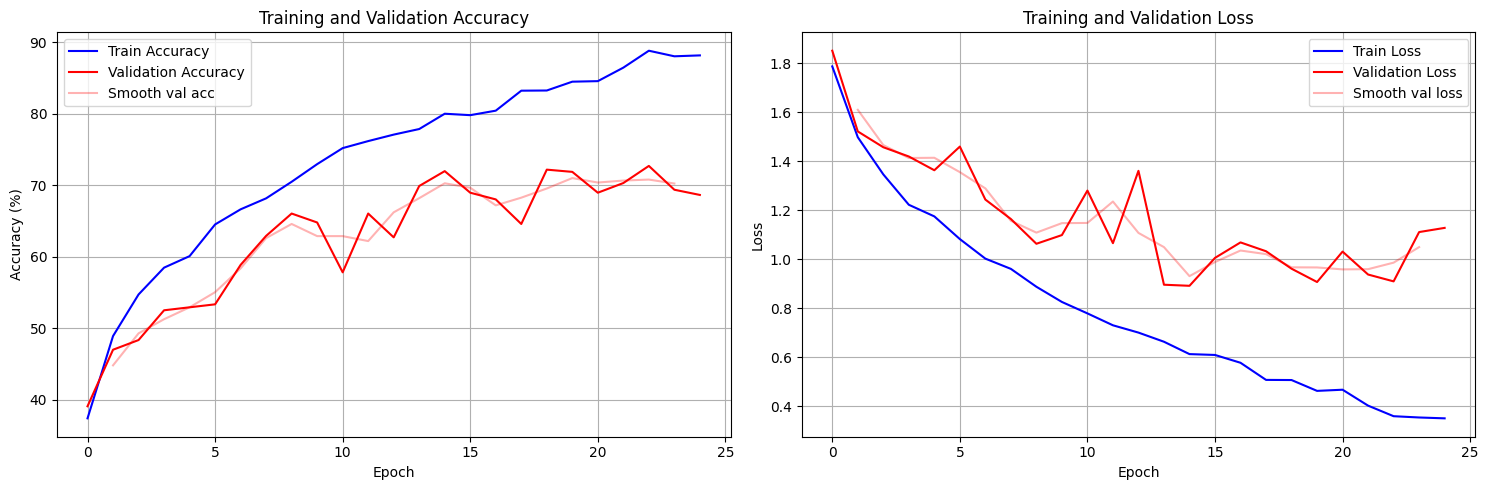

In [33]:
plot_training_history(history_3_1_B)

| Этап | Конфигурация  | Параметры     | Val Accuracy (%) | Train Accuracy (%) |
|------|---------------|---------------|------------------|--------------------|
| 3.1  |3.1-A          | 2 788 490     | 74.69            | 91.96              |
| 3.1  |3.1-B          | 2 741 002     | 72.71            | 88.84              |

**Вывод:** лучше конфигурация 3.1-A, она дала лучше результат по val accuracy. Также заметно начало переобучения у обеих моделей после ~15 эпохи.

### 3.2: Эксперименты с количеством residual блоков

In [34]:
class Model32A(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 32)
        self.basic_block_2_0 = BasicBlock(32, 64, 2)
        self.basic_block_3_0 = BasicBlock(64, 128, 2)
        self.basic_block_4_0 = BasicBlock(128, 256, 2)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_0(x)
        x = self.basic_block_2_0(x)
        x = self.basic_block_3_0(x)
        x = self.basic_block_4_0(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [35]:
model_3_2_A = Model32A()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_2_A(test_input)
print(output.shape)

torch.Size([1, 10])


In [36]:
total_params = sum(p.numel() for p in model_3_2_A.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 1,219,850


In [37]:
optimizer = torch.optim.Adam(model_3_2_A.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_2_A = train_model(
    model=model_3_2_A,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_32A.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.81it/s]


 Train Loss: 1.6739, Train Acc: 43.17%
 Val Loss: 1.6323, Val Acc: 47.29%
 Сохранена лучшая модель с точностью 47.29%
 Эпоха 2/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.62it/s]


 Train Loss: 1.3606, Train Acc: 53.98%
 Val Loss: 1.3606, Val Acc: 52.71%
 Сохранена лучшая модель с точностью 52.71%
 Эпоха 3/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.45it/s]


 Train Loss: 1.1730, Train Acc: 60.76%
 Val Loss: 1.5379, Val Acc: 50.94%
 Эпоха 4/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.89it/s]


 Train Loss: 1.0525, Train Acc: 65.42%
 Val Loss: 1.1562, Val Acc: 61.98%
 Сохранена лучшая модель с точностью 61.98%
 Эпоха 5/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.77it/s]


 Train Loss: 0.9408, Train Acc: 69.30%
 Val Loss: 1.2182, Val Acc: 57.40%
 Эпоха 6/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 10.63it/s]


 Train Loss: 0.8165, Train Acc: 73.03%
 Val Loss: 1.0523, Val Acc: 62.71%
 Сохранена лучшая модель с точностью 62.71%
 Эпоха 7/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.63it/s]


 Train Loss: 0.7200, Train Acc: 76.56%
 Val Loss: 1.0909, Val Acc: 64.27%
 Сохранена лучшая модель с точностью 64.27%
 Эпоха 8/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.13it/s]


 Train Loss: 0.6591, Train Acc: 78.00%
 Val Loss: 1.2236, Val Acc: 59.90%
 Эпоха 9/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.53it/s]


 Train Loss: 0.6081, Train Acc: 79.54%
 Val Loss: 1.0933, Val Acc: 63.23%
 Эпоха 10/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.22it/s]


 Train Loss: 0.5226, Train Acc: 82.76%
 Val Loss: 0.8371, Val Acc: 73.12%
 Сохранена лучшая модель с точностью 73.12%
 Эпоха 11/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.23it/s]


 Train Loss: 0.4408, Train Acc: 86.01%
 Val Loss: 1.0907, Val Acc: 66.88%
 Эпоха 12/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.91it/s]


 Train Loss: 0.3648, Train Acc: 88.68%
 Val Loss: 0.8604, Val Acc: 73.96%
 Сохранена лучшая модель с точностью 73.96%
 Эпоха 13/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.70it/s]


 Train Loss: 0.2793, Train Acc: 91.81%
 Val Loss: 1.3910, Val Acc: 58.23%
 Эпоха 14/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.07it/s]


 Train Loss: 0.2267, Train Acc: 93.45%
 Val Loss: 1.0807, Val Acc: 68.54%
 Эпоха 15/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.76it/s]


 Train Loss: 0.1690, Train Acc: 95.51%
 Val Loss: 1.0055, Val Acc: 72.19%
 Эпоха 16/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.98it/s]


 Train Loss: 0.1190, Train Acc: 97.03%
 Val Loss: 1.2903, Val Acc: 67.19%
 Эпоха 17/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.49it/s]


 Train Loss: 0.0873, Train Acc: 97.88%
 Val Loss: 0.9713, Val Acc: 73.44%
 Эпоха 18/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


 Train Loss: 0.0655, Train Acc: 98.71%
 Val Loss: 1.4734, Val Acc: 65.73%
 Эпоха 19/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.22it/s]


 Train Loss: 0.0603, Train Acc: 98.87%
 Val Loss: 1.1953, Val Acc: 66.15%
 Эпоха 20/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.46it/s]


 Train Loss: 0.0538, Train Acc: 98.77%
 Val Loss: 1.0486, Val Acc: 71.77%
 Эпоха 21/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 17.08it/s]


 Train Loss: 0.0384, Train Acc: 99.42%
 Val Loss: 1.0936, Val Acc: 73.23%
 Эпоха 22/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


 Train Loss: 0.0231, Train Acc: 99.62%
 Val Loss: 1.5838, Val Acc: 63.85%
 Эпоха 23/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.01it/s]


 Train Loss: 0.0264, Train Acc: 99.47%
 Val Loss: 0.8765, Val Acc: 75.31%
 Сохранена лучшая модель с точностью 75.31%
 Эпоха 24/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.38it/s]


 Train Loss: 0.0393, Train Acc: 99.04%
 Val Loss: 1.0061, Val Acc: 73.54%
 Эпоха 25/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 23.91it/s]

 Train Loss: 0.0531, Train Acc: 98.71%
 Val Loss: 1.2822, Val Acc: 68.75%


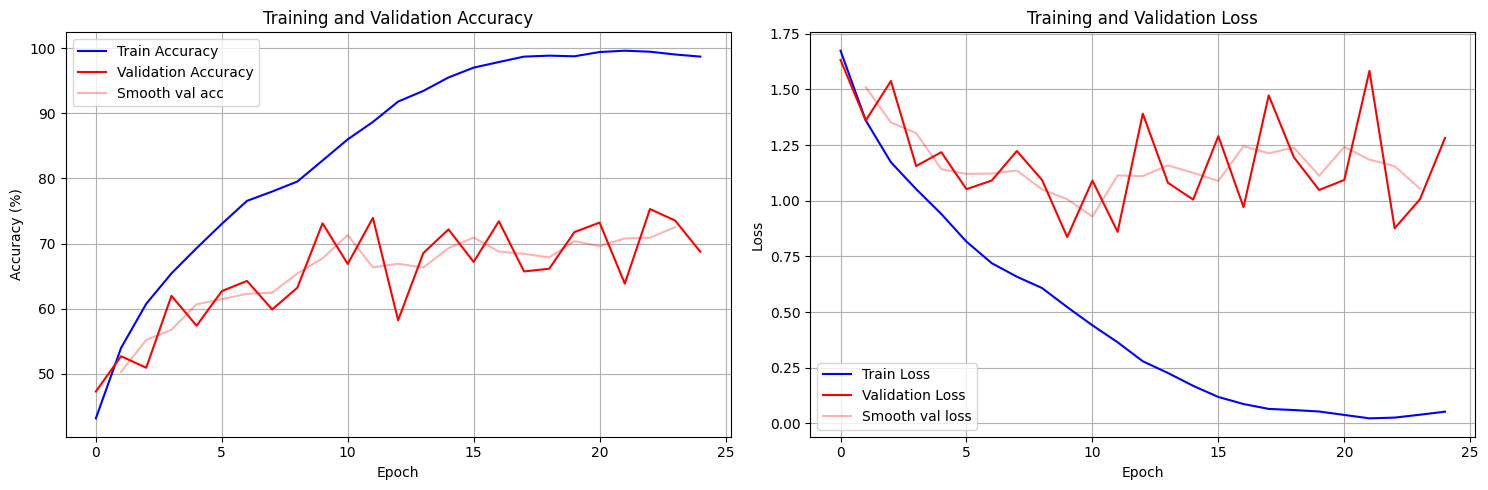

In [38]:
plot_training_history(history_3_2_A)

In [39]:
class Model32C(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 32, 2)
        self.basic_block_1_1 = BasicBlock(32, 32)
        self.basic_block_1_2 = BasicBlock(32, 32)

        self.basic_block_2_0 = BasicBlock(32, 64, 2)
        self.basic_block_2_1 = BasicBlock(64, 64)
        self.basic_block_2_2 = BasicBlock(64, 64)

        self.basic_block_3_0 = BasicBlock(64, 128, 2)
        self.basic_block_3_1 = BasicBlock(128, 128)
        self.basic_block_3_2 = BasicBlock(128, 128)

        self.basic_block_4_0 = BasicBlock(128, 256, 2)
        self.basic_block_4_1 = BasicBlock(256, 256)
        self.basic_block_4_2 = BasicBlock(256, 256)


        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_2(self.basic_block_1_1(self.basic_block_1_0(x)))
        x = self.basic_block_2_2(self.basic_block_2_1(self.basic_block_2_0(x)))
        x = self.basic_block_3_2(self.basic_block_3_1(self.basic_block_3_0(x)))
        x = self.basic_block_4_2(self.basic_block_4_1(self.basic_block_4_0(x)))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [40]:
model_3_2_C = Model32C()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_2_C(test_input)
print(output.shape)

torch.Size([1, 10])


In [41]:
total_params = sum(p.numel() for p in model_3_2_C.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 4,291,082


In [42]:
optimizer = torch.optim.Adam(model_3_2_C.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_2_C = train_model(
    model=model_3_2_C,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_32C.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.58it/s]


 Train Loss: 1.7677, Train Acc: 38.86%
 Val Loss: 1.6783, Val Acc: 42.50%
 Сохранена лучшая модель с точностью 42.50%
 Эпоха 2/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.33it/s]


 Train Loss: 1.4481, Train Acc: 50.81%
 Val Loss: 1.5134, Val Acc: 49.38%
 Сохранена лучшая модель с точностью 49.38%
 Эпоха 3/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.67it/s]


 Train Loss: 1.2719, Train Acc: 56.53%
 Val Loss: 1.4423, Val Acc: 51.67%
 Сохранена лучшая модель с точностью 51.67%
 Эпоха 4/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.35it/s]


 Train Loss: 1.1489, Train Acc: 61.19%
 Val Loss: 1.6068, Val Acc: 48.44%
 Эпоха 5/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.96it/s]


 Train Loss: 1.0259, Train Acc: 65.70%
 Val Loss: 1.2834, Val Acc: 55.94%
 Сохранена лучшая модель с точностью 55.94%
 Эпоха 6/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.10it/s]


 Train Loss: 0.9564, Train Acc: 67.57%
 Val Loss: 1.2992, Val Acc: 58.23%
 Сохранена лучшая модель с точностью 58.23%
 Эпоха 7/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.10it/s]


 Train Loss: 0.8827, Train Acc: 69.98%
 Val Loss: 1.1201, Val Acc: 63.54%
 Сохранена лучшая модель с точностью 63.54%
 Эпоха 8/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.54it/s]


 Train Loss: 0.8182, Train Acc: 72.28%
 Val Loss: 1.0838, Val Acc: 65.10%
 Сохранена лучшая модель с точностью 65.10%
 Эпоха 9/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.01it/s]


 Train Loss: 0.7659, Train Acc: 73.79%
 Val Loss: 1.2832, Val Acc: 59.90%
 Эпоха 10/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.01it/s]


 Train Loss: 0.6985, Train Acc: 76.21%
 Val Loss: 0.8941, Val Acc: 70.62%
 Сохранена лучшая модель с точностью 70.62%
 Эпоха 11/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.80it/s]


 Train Loss: 0.6498, Train Acc: 77.27%
 Val Loss: 1.6180, Val Acc: 55.83%
 Эпоха 12/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.17it/s]


 Train Loss: 0.5876, Train Acc: 79.74%
 Val Loss: 0.9822, Val Acc: 68.75%
 Эпоха 13/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.27it/s]


 Train Loss: 0.5307, Train Acc: 81.40%
 Val Loss: 1.3920, Val Acc: 60.52%
 Эпоха 14/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.11it/s]


 Train Loss: 0.4782, Train Acc: 83.80%
 Val Loss: 0.9587, Val Acc: 70.10%
 Эпоха 15/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


 Train Loss: 0.4388, Train Acc: 84.98%
 Val Loss: 1.1037, Val Acc: 68.23%
 Эпоха 16/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.17it/s]


 Train Loss: 0.3908, Train Acc: 86.77%
 Val Loss: 1.1940, Val Acc: 67.19%
 Эпоха 17/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.79it/s]


 Train Loss: 0.3315, Train Acc: 88.53%
 Val Loss: 1.1161, Val Acc: 70.83%
 Сохранена лучшая модель с точностью 70.83%
 Эпоха 18/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.72it/s]


 Train Loss: 0.3116, Train Acc: 89.44%
 Val Loss: 1.2342, Val Acc: 67.60%
 Эпоха 19/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.82it/s]


 Train Loss: 0.2851, Train Acc: 90.10%
 Val Loss: 1.3502, Val Acc: 66.04%
 Эпоха 20/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.94it/s]


 Train Loss: 0.2627, Train Acc: 90.70%
 Val Loss: 1.2132, Val Acc: 69.69%
 Эпоха 21/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.35it/s]


 Train Loss: 0.1913, Train Acc: 93.85%
 Val Loss: 1.2889, Val Acc: 66.98%
 Эпоха 22/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.20it/s]


 Train Loss: 0.2022, Train Acc: 92.69%
 Val Loss: 1.5102, Val Acc: 65.73%
 Эпоха 23/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.98it/s]


 Train Loss: 0.2033, Train Acc: 92.97%
 Val Loss: 1.0630, Val Acc: 72.50%
 Сохранена лучшая модель с точностью 72.50%
 Эпоха 24/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.89it/s]


 Train Loss: 0.1322, Train Acc: 95.72%
 Val Loss: 1.7546, Val Acc: 64.27%
 Эпоха 25/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.54it/s]

 Train Loss: 0.1094, Train Acc: 96.85%
 Val Loss: 1.4219, Val Acc: 70.42%


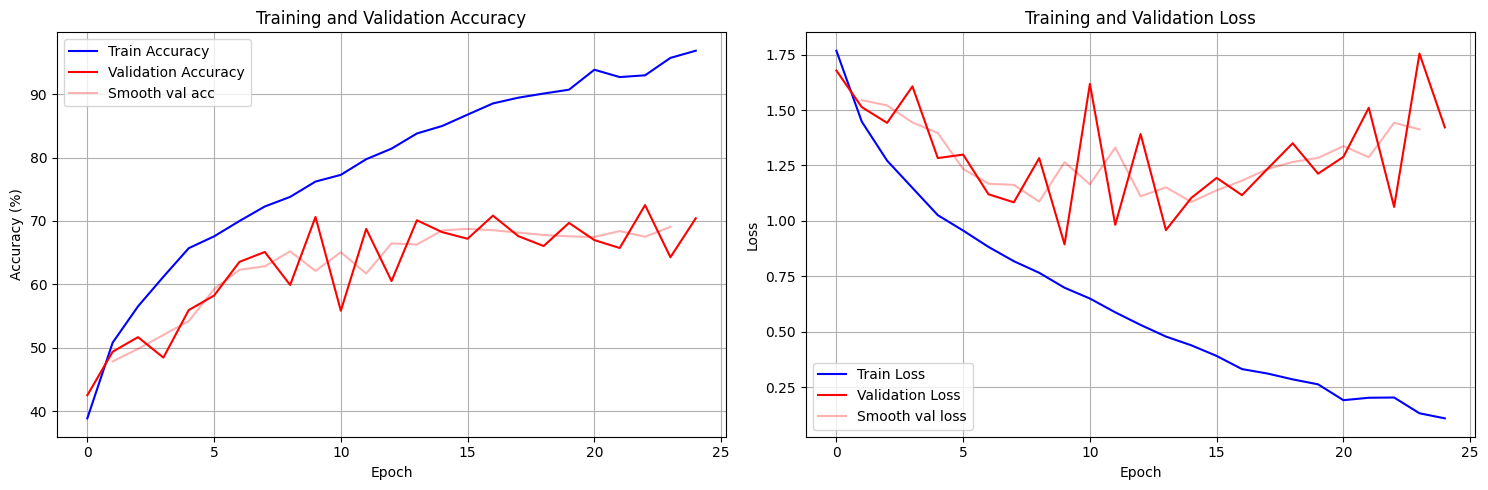

In [43]:
plot_training_history(history_3_2_C)

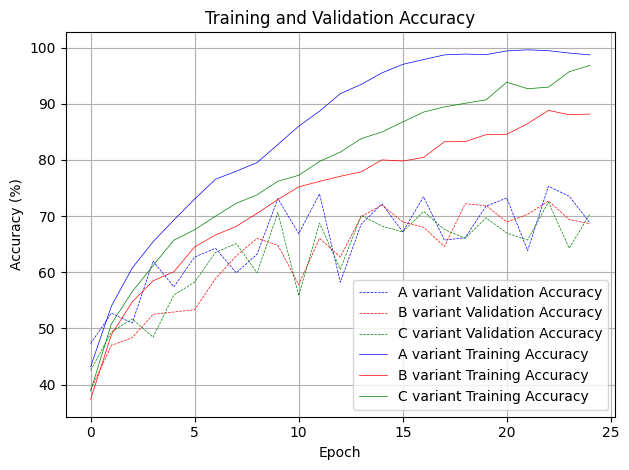

In [44]:
plt.plot(history_3_2_A['val_acc'], label='A variant Validation Accuracy', color='blue', linewidth=0.5, linestyle="dashed")
plt.plot(history_3_1_B['val_acc'], label='B variant Validation Accuracy', color='red', linewidth=0.5, linestyle="dashed")
plt.plot(history_3_2_C['val_acc'], label='C variant Validation Accuracy', color='green', linewidth=0.5, linestyle="dashed")

plt.plot(history_3_2_A['train_acc'], label='A variant Training Accuracy', color='blue', linewidth=0.5)
plt.plot(history_3_1_B['train_acc'], label='B variant Training Accuracy', color='red', linewidth=0.5)
plt.plot(history_3_2_C['train_acc'], label='C variant Training Accuracy', color='green', linewidth=0.5)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Вариант B - это модель из 3.1

| Этап | Конфигурация  | Параметры     | Val Accuracy (%) |Train Accuracy (%) |Эпоха с лучшим результатом|
|------|---------------|---------------|------------------|-------------------|--------------------------|
| 3.2  |3.2-A          | 1 219 850     | 75.31             | 99.47             |23                        |
| 3.2  |3.2-B          | 2 788 490     | 74.69            | 91.96                         |16                        |
| 3.2  |3.2-C          | 4 291 082     | 72.50             | 92.97             |23                        |

**Вывод:** модель 3.2-A с 1 блоком оптимальна, у неё валидационная точность выше и в отличие от более глубоких моделей с 2 и 3 блоками.

### 3.3: Эксперименты с функциями активации

In [45]:
class Model33B(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 32, activation="leakyrelu")
        self.basic_block_2_0 = BasicBlock(32, 64, 2, activation="leakyrelu")
        self.basic_block_3_0 = BasicBlock(64, 128, 2, activation="leakyrelu")
        self.basic_block_4_0 = BasicBlock(128, 256, 2, activation="leakyrelu")

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_0(x)
        x = self.basic_block_2_0(x)
        x = self.basic_block_3_0(x)
        x = self.basic_block_4_0(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [46]:
model_3_3_B = Model33B()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_3_B(test_input)
print(output.shape)

torch.Size([1, 10])


In [47]:
total_params = sum(p.numel() for p in model_3_3_B.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 1,219,850


In [48]:
optimizer = torch.optim.Adam(model_3_3_B.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_3_B = train_model(
    model=model_3_3_B,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_33B.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.32it/s]


 Train Loss: 1.6555, Train Acc: 42.87%
 Val Loss: 1.5837, Val Acc: 46.67%
 Сохранена лучшая модель с точностью 46.67%
 Эпоха 2/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.74it/s]


 Train Loss: 1.3308, Train Acc: 55.65%
 Val Loss: 1.3219, Val Acc: 55.00%
 Сохранена лучшая модель с точностью 55.00%
 Эпоха 3/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.60it/s]


 Train Loss: 1.1417, Train Acc: 62.20%
 Val Loss: 1.1848, Val Acc: 61.56%
 Сохранена лучшая модель с точностью 61.56%
 Эпоха 4/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.15it/s]


 Train Loss: 1.0206, Train Acc: 66.05%
 Val Loss: 1.0991, Val Acc: 60.94%
 Эпоха 5/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 19.60it/s]


 Train Loss: 0.9154, Train Acc: 70.04%
 Val Loss: 1.1964, Val Acc: 61.04%
 Эпоха 6/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.57it/s]


 Train Loss: 0.8149, Train Acc: 73.41%
 Val Loss: 1.2127, Val Acc: 63.23%
 Сохранена лучшая модель с точностью 63.23%
 Эпоха 7/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.42it/s]


 Train Loss: 0.7428, Train Acc: 75.68%
 Val Loss: 0.9099, Val Acc: 69.17%
 Сохранена лучшая модель с точностью 69.17%
 Эпоха 8/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.22it/s]


 Train Loss: 0.6717, Train Acc: 77.60%
 Val Loss: 0.8982, Val Acc: 70.83%
 Сохранена лучшая модель с точностью 70.83%
 Эпоха 9/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.60it/s]


 Train Loss: 0.5943, Train Acc: 80.87%
 Val Loss: 0.9858, Val Acc: 65.31%
 Эпоха 10/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.06it/s]


 Train Loss: 0.5517, Train Acc: 82.33%
 Val Loss: 1.0505, Val Acc: 65.10%
 Эпоха 11/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.34it/s]


 Train Loss: 0.5078, Train Acc: 82.74%
 Val Loss: 1.0783, Val Acc: 65.31%
 Эпоха 12/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.08it/s]


 Train Loss: 0.4031, Train Acc: 86.24%
 Val Loss: 0.9583, Val Acc: 69.38%
 Эпоха 13/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.13it/s]


 Train Loss: 0.3480, Train Acc: 88.84%
 Val Loss: 1.7946, Val Acc: 57.92%
 Эпоха 14/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.38it/s]


 Train Loss: 0.2765, Train Acc: 91.78%
 Val Loss: 1.6714, Val Acc: 61.46%
 Эпоха 15/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.29it/s]


 Train Loss: 0.2471, Train Acc: 92.92%
 Val Loss: 1.2285, Val Acc: 65.42%
 Эпоха 16/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.75it/s]


 Train Loss: 0.1742, Train Acc: 95.24%
 Val Loss: 0.9831, Val Acc: 68.54%
 Эпоха 17/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.99it/s]


 Train Loss: 0.1092, Train Acc: 97.56%
 Val Loss: 0.9277, Val Acc: 74.17%
 Сохранена лучшая модель с точностью 74.17%
 Эпоха 18/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


 Train Loss: 0.0745, Train Acc: 98.44%
 Val Loss: 1.5872, Val Acc: 62.60%
 Эпоха 19/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.60it/s]


 Train Loss: 0.0637, Train Acc: 98.64%
 Val Loss: 1.1533, Val Acc: 69.17%
 Эпоха 20/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.63it/s]


 Train Loss: 0.0710, Train Acc: 98.59%
 Val Loss: 1.0547, Val Acc: 71.77%
 Эпоха 21/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.06it/s]


 Train Loss: 0.0495, Train Acc: 99.07%
 Val Loss: 1.6649, Val Acc: 66.67%
 Эпоха 22/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.00it/s]


 Train Loss: 0.0476, Train Acc: 98.84%
 Val Loss: 1.1486, Val Acc: 71.56%
 Эпоха 23/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.15it/s]


 Train Loss: 0.0640, Train Acc: 98.06%
 Val Loss: 1.5553, Val Acc: 64.79%
 Эпоха 24/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.62it/s]


 Train Loss: 0.1011, Train Acc: 96.85%
 Val Loss: 1.8004, Val Acc: 64.79%
 Эпоха 25/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.79it/s]

 Train Loss: 0.0793, Train Acc: 97.96%
 Val Loss: 1.0993, Val Acc: 71.77%


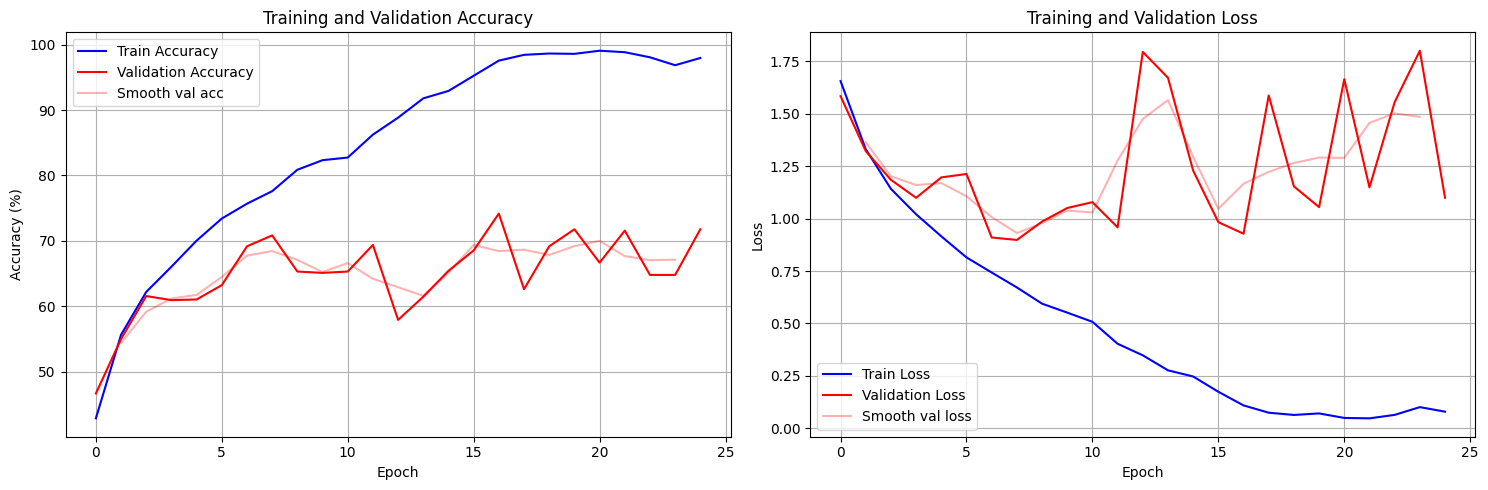

In [49]:
plot_training_history(history_3_3_B)

In [50]:
class Model33C(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 32, activation="elu")
        self.basic_block_2_0 = BasicBlock(32, 64, 2, activation="elu")
        self.basic_block_3_0 = BasicBlock(64, 128, 2, activation="elu")
        self.basic_block_4_0 = BasicBlock(128, 256, 2, activation="elu")

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_0(x)
        x = self.basic_block_2_0(x)
        x = self.basic_block_3_0(x)
        x = self.basic_block_4_0(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [51]:
model_3_3_C = Model33C()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_3_C(test_input)
print(output.shape)

torch.Size([1, 10])


In [52]:
optimizer = torch.optim.Adam(model_3_3_C.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_3_C = train_model(
    model=model_3_3_C,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_33C.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.42it/s]


 Train Loss: 1.7926, Train Acc: 36.32%
 Val Loss: 1.7490, Val Acc: 41.77%
 Сохранена лучшая модель с точностью 41.77%
 Эпоха 2/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.48it/s]


 Train Loss: 1.4909, Train Acc: 47.91%
 Val Loss: 1.5149, Val Acc: 47.71%
 Сохранена лучшая модель с точностью 47.71%
 Эпоха 3/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.51it/s]


 Train Loss: 1.3961, Train Acc: 52.04%
 Val Loss: 1.4552, Val Acc: 51.04%
 Сохранена лучшая модель с точностью 51.04%
 Эпоха 4/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.02it/s]


 Train Loss: 1.2841, Train Acc: 56.68%
 Val Loss: 1.4736, Val Acc: 52.60%
 Сохранена лучшая модель с точностью 52.60%
 Эпоха 5/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.26it/s]


 Train Loss: 1.2476, Train Acc: 57.59%
 Val Loss: 1.2514, Val Acc: 56.15%
 Сохранена лучшая модель с точностью 56.15%
 Эпоха 6/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 23.96it/s]


 Train Loss: 1.1455, Train Acc: 62.12%
 Val Loss: 1.2488, Val Acc: 58.23%
 Сохранена лучшая модель с точностью 58.23%
 Эпоха 7/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.63it/s]


 Train Loss: 1.0913, Train Acc: 63.61%
 Val Loss: 1.1951, Val Acc: 59.58%
 Сохранена лучшая модель с точностью 59.58%
 Эпоха 8/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.45it/s]


 Train Loss: 1.0368, Train Acc: 64.97%
 Val Loss: 1.1305, Val Acc: 60.21%
 Сохранена лучшая модель с точностью 60.21%
 Эпоха 9/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.01it/s]


 Train Loss: 0.9765, Train Acc: 67.82%
 Val Loss: 1.0735, Val Acc: 63.65%
 Сохранена лучшая модель с точностью 63.65%
 Эпоха 10/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.34it/s]


 Train Loss: 0.9174, Train Acc: 69.91%
 Val Loss: 1.1247, Val Acc: 62.81%
 Эпоха 11/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.60it/s]


 Train Loss: 0.8916, Train Acc: 69.78%
 Val Loss: 1.2003, Val Acc: 60.42%
 Эпоха 12/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.29it/s]


 Train Loss: 0.8322, Train Acc: 72.00%
 Val Loss: 0.9764, Val Acc: 68.33%
 Сохранена лучшая модель с точностью 68.33%
 Эпоха 13/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 19.39it/s]


 Train Loss: 0.7831, Train Acc: 73.74%
 Val Loss: 0.9240, Val Acc: 68.96%
 Сохранена лучшая модель с точностью 68.96%
 Эпоха 14/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.44it/s]


 Train Loss: 0.7326, Train Acc: 75.81%
 Val Loss: 1.0062, Val Acc: 68.23%
 Эпоха 15/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.48it/s]


 Train Loss: 0.7181, Train Acc: 75.83%
 Val Loss: 1.0072, Val Acc: 66.56%
 Эпоха 16/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.11it/s]


 Train Loss: 0.6758, Train Acc: 77.44%
 Val Loss: 1.0327, Val Acc: 66.77%
 Эпоха 17/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.63it/s]


 Train Loss: 0.6385, Train Acc: 78.53%
 Val Loss: 0.9943, Val Acc: 68.85%
 Эпоха 18/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.56it/s]


 Train Loss: 0.6150, Train Acc: 79.16%
 Val Loss: 0.9593, Val Acc: 69.79%
 Сохранена лучшая модель с точностью 69.79%
 Эпоха 19/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.00it/s]


 Train Loss: 0.5605, Train Acc: 80.85%
 Val Loss: 0.9921, Val Acc: 66.88%
 Эпоха 20/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 19.47it/s]


 Train Loss: 0.5129, Train Acc: 82.76%
 Val Loss: 0.9652, Val Acc: 69.38%
 Эпоха 21/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 18.65it/s]


 Train Loss: 0.4681, Train Acc: 84.53%
 Val Loss: 1.0984, Val Acc: 66.56%
 Эпоха 22/25


Validation: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


 Train Loss: 0.4285, Train Acc: 86.06%
 Val Loss: 1.0303, Val Acc: 69.38%
 Эпоха 23/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


 Train Loss: 0.3723, Train Acc: 87.78%
 Val Loss: 0.9654, Val Acc: 69.69%
 Эпоха 24/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.25it/s]


 Train Loss: 0.3295, Train Acc: 89.16%
 Val Loss: 1.0528, Val Acc: 70.10%
 Сохранена лучшая модель с точностью 70.10%
 Эпоха 25/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.14it/s]

 Train Loss: 0.3029, Train Acc: 90.50%
 Val Loss: 1.0054, Val Acc: 71.15%
 Сохранена лучшая модель с точностью 71.15%


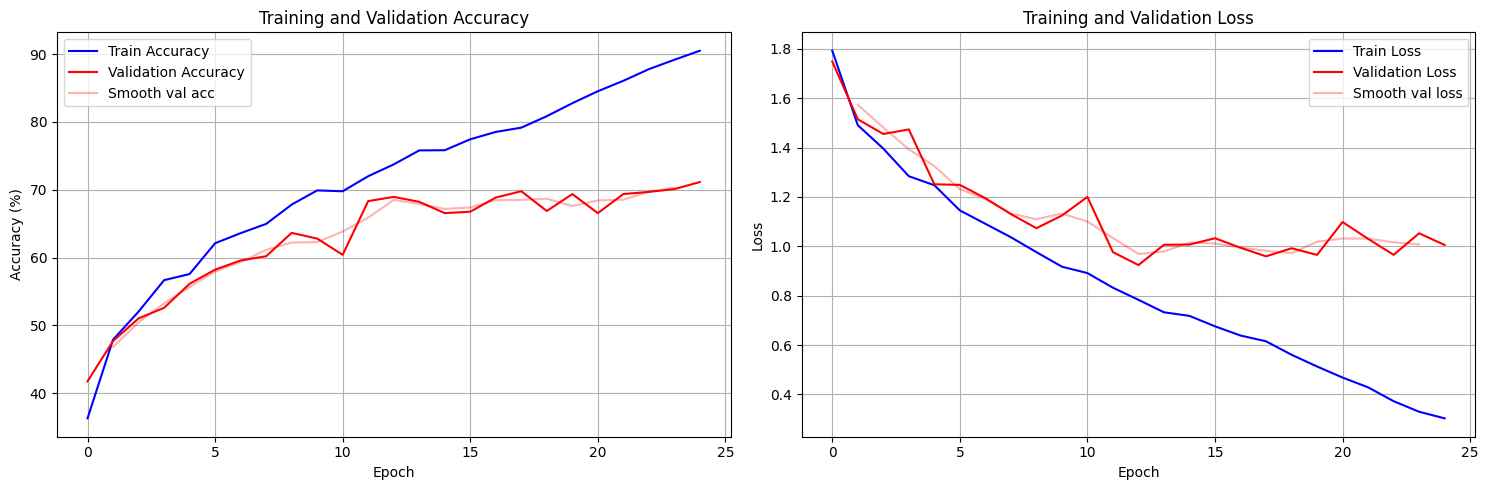

In [53]:
plot_training_history(history_3_3_C)

In [54]:
class Model33D(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 32, activation="gelu")
        self.basic_block_2_0 = BasicBlock(32, 64, 2, activation="gelu")
        self.basic_block_3_0 = BasicBlock(64, 128, 2, activation="gelu")
        self.basic_block_4_0 = BasicBlock(128, 256, 2, activation="gelu")
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_0(x)
        x = self.basic_block_2_0(x)
        x = self.basic_block_3_0(x)
        x = self.basic_block_4_0(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [55]:
model_3_3_D = Model33D()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_3_D(test_input)
print(output.shape)

torch.Size([1, 10])


In [56]:
optimizer = torch.optim.Adam(model_3_3_D.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_3_D = train_model(
    model=model_3_3_D,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_33D.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.51it/s]


 Train Loss: 1.6666, Train Acc: 41.78%
 Val Loss: 1.6908, Val Acc: 47.71%
 Сохранена лучшая модель с точностью 47.71%
 Эпоха 2/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 26.10it/s]


 Train Loss: 1.3326, Train Acc: 54.39%
 Val Loss: 1.4300, Val Acc: 53.33%
 Сохранена лучшая модель с точностью 53.33%
 Эпоха 3/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.33it/s]


 Train Loss: 1.1492, Train Acc: 61.82%
 Val Loss: 1.1785, Val Acc: 62.50%
 Сохранена лучшая модель с точностью 62.50%
 Эпоха 4/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.49it/s]


 Train Loss: 0.9748, Train Acc: 67.79%
 Val Loss: 1.2617, Val Acc: 60.21%
 Эпоха 5/25


Validation: 100%|██████████| 15/15 [00:01<00:00, 13.58it/s]


 Train Loss: 0.9013, Train Acc: 70.44%
 Val Loss: 1.3035, Val Acc: 62.29%
 Эпоха 6/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.12it/s]


 Train Loss: 0.8255, Train Acc: 72.83%
 Val Loss: 1.2861, Val Acc: 61.04%
 Эпоха 7/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 19.96it/s]


 Train Loss: 0.7188, Train Acc: 75.58%
 Val Loss: 1.1367, Val Acc: 64.27%
 Сохранена лучшая модель с точностью 64.27%
 Эпоха 8/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.63it/s]


 Train Loss: 0.6630, Train Acc: 77.75%
 Val Loss: 1.0403, Val Acc: 68.75%
 Сохранена лучшая модель с точностью 68.75%
 Эпоха 9/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.41it/s]


 Train Loss: 0.6142, Train Acc: 79.74%
 Val Loss: 1.0016, Val Acc: 69.69%
 Сохранена лучшая модель с точностью 69.69%
 Эпоха 10/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.36it/s]


 Train Loss: 0.4966, Train Acc: 84.05%
 Val Loss: 0.9713, Val Acc: 66.15%
 Эпоха 11/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.67it/s]


 Train Loss: 0.4352, Train Acc: 85.56%
 Val Loss: 0.9991, Val Acc: 69.79%
 Сохранена лучшая модель с точностью 69.79%
 Эпоха 12/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.17it/s]


 Train Loss: 0.3721, Train Acc: 88.43%
 Val Loss: 1.0985, Val Acc: 68.23%
 Эпоха 13/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.23it/s]


 Train Loss: 0.3136, Train Acc: 90.07%
 Val Loss: 0.9691, Val Acc: 68.44%
 Эпоха 14/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.42it/s]


 Train Loss: 0.2308, Train Acc: 94.00%
 Val Loss: 0.9632, Val Acc: 69.90%
 Сохранена лучшая модель с точностью 69.90%
 Эпоха 15/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.48it/s]


 Train Loss: 0.1796, Train Acc: 95.26%
 Val Loss: 1.2043, Val Acc: 66.88%
 Эпоха 16/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.59it/s]


 Train Loss: 0.1375, Train Acc: 96.30%
 Val Loss: 0.9886, Val Acc: 71.67%
 Сохранена лучшая модель с точностью 71.67%
 Эпоха 17/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.11it/s]


 Train Loss: 0.1196, Train Acc: 97.08%
 Val Loss: 0.9165, Val Acc: 73.75%
 Сохранена лучшая модель с точностью 73.75%
 Эпоха 18/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


 Train Loss: 0.0814, Train Acc: 98.01%
 Val Loss: 0.9049, Val Acc: 74.06%
 Сохранена лучшая модель с точностью 74.06%
 Эпоха 19/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 19.95it/s]


 Train Loss: 0.0561, Train Acc: 98.97%
 Val Loss: 1.0187, Val Acc: 72.81%
 Эпоха 20/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.83it/s]


 Train Loss: 0.0465, Train Acc: 98.92%
 Val Loss: 1.0287, Val Acc: 71.77%
 Эпоха 21/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.74it/s]


 Train Loss: 0.0215, Train Acc: 99.77%
 Val Loss: 0.8704, Val Acc: 76.67%
 Сохранена лучшая модель с точностью 76.67%
 Эпоха 22/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.64it/s]


 Train Loss: 0.0225, Train Acc: 99.62%
 Val Loss: 0.9632, Val Acc: 74.58%
 Эпоха 23/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.14it/s]


 Train Loss: 0.0193, Train Acc: 99.72%
 Val Loss: 0.8859, Val Acc: 76.88%
 Сохранена лучшая модель с точностью 76.88%
 Эпоха 24/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.50it/s]


 Train Loss: 0.0168, Train Acc: 99.77%
 Val Loss: 1.0913, Val Acc: 72.29%
 Эпоха 25/25


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.09it/s]

 Train Loss: 0.0145, Train Acc: 99.87%
 Val Loss: 0.9182, Val Acc: 75.52%


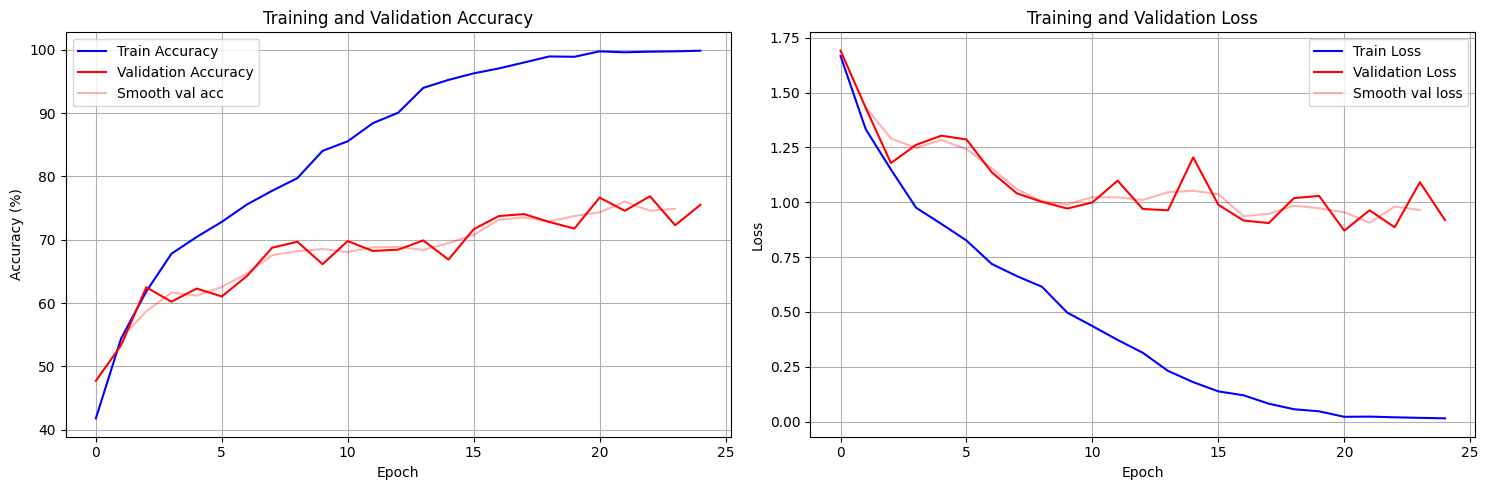

In [57]:
plot_training_history(history_3_3_D)

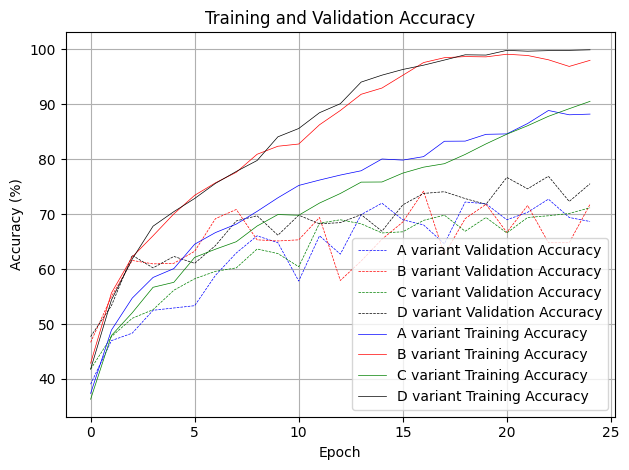

In [58]:
plt.plot(history_3_1_B['val_acc'], label='A variant Validation Accuracy', color='blue', linewidth=0.5, linestyle="dashed")
plt.plot(history_3_3_B['val_acc'], label='B variant Validation Accuracy', color='red', linewidth=0.5, linestyle="dashed")
plt.plot(history_3_3_C['val_acc'], label='C variant Validation Accuracy', color='green', linewidth=0.5, linestyle="dashed")
plt.plot(history_3_3_D['val_acc'], label='D variant Validation Accuracy', color='black', linewidth=0.5, linestyle="dashed")

plt.plot(history_3_1_B['train_acc'], label='A variant Training Accuracy', color='blue', linewidth=0.5)
plt.plot(history_3_3_B['train_acc'], label='B variant Training Accuracy', color='red', linewidth=0.5)
plt.plot(history_3_3_C['train_acc'], label='C variant Training Accuracy', color='green', linewidth=0.5)
plt.plot(history_3_3_D['train_acc'], label='D variant Training Accuracy', color='black', linewidth=0.5)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

| Этап | Конфигурация  | Параметры     | Val Accuracy (%) |Train Accuracy (%) |Эпоха с лучшим результатом|
|------|---------------|---------------|------------------|-------------------|--------------------------|
| 3.3  |3.3-A          | 1 219 850     | 75.31           | 99.47              |23                        |
| 3.3  |3.3-B          | 1 219 850     | 74.17	         | 97.56             |17                        |
| 3.3  |3.3-C          | 1 219 850     | 71.15             | 90.50             |25                        |
| 3.3  |3.3-D          | 1 219 850     | 76.88             | 99.72             |23                        |

**Вывод:** ReLU и GELU показали сравнимые результаты, они обе являются хорошим выбором. Но GELU показала наивысшую валидационную точность, превзойдя другие функции активации. Поэтому для данной архитектуры GeLU — оптимальный выбор.

## Часть 4: Финальная модель и тестирование

### 4.1: Создание финальной модели

In [59]:
model_final = Model33D()

In [60]:
optimizer = torch.optim.Adam(model_final.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_final = train_model(
    model=model_final,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=40,
    model_path="model_final.pth"
)

cuda
Обучение на 40 эпох...
 Эпоха 1/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.75it/s]


 Train Loss: 1.6468, Train Acc: 43.98%
 Val Loss: 1.4773, Val Acc: 45.94%
 Сохранена лучшая модель с точностью 45.94%
 Эпоха 2/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.79it/s]


 Train Loss: 1.3110, Train Acc: 55.57%
 Val Loss: 1.8497, Val Acc: 48.02%
 Сохранена лучшая модель с точностью 48.02%
 Эпоха 3/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 23.37it/s]


 Train Loss: 1.1258, Train Acc: 62.68%
 Val Loss: 1.3298, Val Acc: 54.27%
 Сохранена лучшая модель с точностью 54.27%
 Эпоха 4/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.05it/s]


 Train Loss: 0.9845, Train Acc: 67.46%
 Val Loss: 1.2477, Val Acc: 58.23%
 Сохранена лучшая модель с точностью 58.23%
 Эпоха 5/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.05it/s]


 Train Loss: 0.9062, Train Acc: 70.41%
 Val Loss: 1.1815, Val Acc: 62.81%
 Сохранена лучшая модель с точностью 62.81%
 Эпоха 6/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 23.91it/s]


 Train Loss: 0.7686, Train Acc: 74.75%
 Val Loss: 0.9094, Val Acc: 70.42%
 Сохранена лучшая модель с точностью 70.42%
 Эпоха 7/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.82it/s]


 Train Loss: 0.6957, Train Acc: 77.67%
 Val Loss: 1.3465, Val Acc: 57.19%
 Эпоха 8/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.26it/s]


 Train Loss: 0.6542, Train Acc: 78.40%
 Val Loss: 1.2448, Val Acc: 59.27%
 Эпоха 9/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.42it/s]


 Train Loss: 0.5733, Train Acc: 80.72%
 Val Loss: 1.1178, Val Acc: 65.21%
 Эпоха 10/40


Validation: 100%|██████████| 15/15 [00:01<00:00, 12.92it/s]


 Train Loss: 0.4601, Train Acc: 85.38%
 Val Loss: 1.2108, Val Acc: 66.15%
 Эпоха 11/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 17.34it/s]


 Train Loss: 0.3717, Train Acc: 88.48%
 Val Loss: 1.6003, Val Acc: 61.04%
 Эпоха 12/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 26.11it/s]


 Train Loss: 0.2945, Train Acc: 91.08%
 Val Loss: 1.5414, Val Acc: 63.02%
 Эпоха 13/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 21.60it/s]


 Train Loss: 0.2326, Train Acc: 93.15%
 Val Loss: 1.1715, Val Acc: 68.65%
 Эпоха 14/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 26.02it/s]


 Train Loss: 0.1890, Train Acc: 94.68%
 Val Loss: 0.9540, Val Acc: 71.46%
 Сохранена лучшая модель с точностью 71.46%
 Эпоха 15/40


Validation: 100%|██████████| 15/15 [00:01<00:00, 11.31it/s]


 Train Loss: 0.1240, Train Acc: 96.93%
 Val Loss: 1.1360, Val Acc: 69.06%
 Эпоха 16/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.15it/s]


 Train Loss: 0.0829, Train Acc: 98.06%
 Val Loss: 1.1183, Val Acc: 70.62%
 Эпоха 17/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.28it/s]


 Train Loss: 0.0635, Train Acc: 98.64%
 Val Loss: 1.1123, Val Acc: 70.73%
 Эпоха 18/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.55it/s]


 Train Loss: 0.0922, Train Acc: 97.35%
 Val Loss: 1.0644, Val Acc: 71.98%
 Сохранена лучшая модель с точностью 71.98%
 Эпоха 19/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 18.75it/s]


 Train Loss: 0.0712, Train Acc: 98.16%
 Val Loss: 1.0623, Val Acc: 73.12%
 Сохранена лучшая модель с точностью 73.12%
 Эпоха 20/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.88it/s]


 Train Loss: 0.0372, Train Acc: 99.32%
 Val Loss: 1.0229, Val Acc: 72.19%
 Эпоха 21/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.69it/s]


 Train Loss: 0.0227, Train Acc: 99.77%
 Val Loss: 0.9758, Val Acc: 74.79%
 Сохранена лучшая модель с точностью 74.79%
 Эпоха 22/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 20.95it/s]


 Train Loss: 0.0121, Train Acc: 99.92%
 Val Loss: 0.9323, Val Acc: 75.21%
 Сохранена лучшая модель с точностью 75.21%
 Эпоха 23/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.20it/s]


 Train Loss: 0.0150, Train Acc: 99.75%
 Val Loss: 0.9573, Val Acc: 73.65%
 Эпоха 24/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.98it/s]


 Train Loss: 0.0092, Train Acc: 99.97%
 Val Loss: 0.9152, Val Acc: 75.62%
 Сохранена лучшая модель с точностью 75.62%
 Эпоха 25/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.17it/s]


 Train Loss: 0.0039, Train Acc: 100.00%
 Val Loss: 0.8935, Val Acc: 77.92%
 Сохранена лучшая модель с точностью 77.92%
 Эпоха 26/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.36it/s]


 Train Loss: 0.0026, Train Acc: 100.00%
 Val Loss: 0.9012, Val Acc: 77.08%
 Эпоха 27/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.02it/s]


 Train Loss: 0.0019, Train Acc: 100.00%
 Val Loss: 0.9107, Val Acc: 77.08%
 Эпоха 28/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.10it/s]


 Train Loss: 0.0015, Train Acc: 100.00%
 Val Loss: 0.8799, Val Acc: 77.19%
 Эпоха 29/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.99it/s]


 Train Loss: 0.0015, Train Acc: 100.00%
 Val Loss: 0.9003, Val Acc: 76.46%
 Эпоха 30/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.27it/s]


 Train Loss: 0.0013, Train Acc: 100.00%
 Val Loss: 0.8776, Val Acc: 76.88%
 Эпоха 31/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.18it/s]


 Train Loss: 0.0010, Train Acc: 100.00%
 Val Loss: 0.8805, Val Acc: 77.08%
 Эпоха 32/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 23.01it/s]


 Train Loss: 0.0010, Train Acc: 100.00%
 Val Loss: 0.9268, Val Acc: 75.62%
 Эпоха 33/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 25.32it/s]


 Train Loss: 0.0011, Train Acc: 100.00%
 Val Loss: 0.8964, Val Acc: 76.35%
 Эпоха 34/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 23.98it/s]


 Train Loss: 0.0009, Train Acc: 100.00%
 Val Loss: 0.8880, Val Acc: 76.67%
 Эпоха 35/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 23.29it/s]


 Train Loss: 0.0007, Train Acc: 100.00%
 Val Loss: 0.8959, Val Acc: 76.88%
 Эпоха 36/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.76it/s]


 Train Loss: 0.0007, Train Acc: 100.00%
 Val Loss: 0.8967, Val Acc: 75.94%
 Эпоха 37/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


 Train Loss: 0.0006, Train Acc: 100.00%
 Val Loss: 0.8933, Val Acc: 76.35%
 Эпоха 38/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.19it/s]


 Train Loss: 0.0007, Train Acc: 100.00%
 Val Loss: 0.8932, Val Acc: 76.77%
 Эпоха 39/40


Validation: 100%|██████████| 15/15 [00:01<00:00,  8.61it/s]


 Train Loss: 0.0007, Train Acc: 100.00%
 Val Loss: 0.8982, Val Acc: 76.35%
 Эпоха 40/40


Validation: 100%|██████████| 15/15 [00:00<00:00, 24.06it/s]

 Train Loss: 0.0005, Train Acc: 100.00%
 Val Loss: 0.8979, Val Acc: 77.29%


### 4.2: Тестирование на test set

In [61]:
all_preds = []
all_labels = []

model_final = model_final.to(device)
model_final.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        predicted = model_final(data)
        _, preds = torch.max(predicted, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

In [62]:
acc = accuracy_score(all_labels, all_preds)

precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)

print(f"Test Accuracy: {acc:.4f}")
print("\nPer-class metrics:")
for i in range(len(selected_classes)):
    print(f"Class {class_names_human[i]:30}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Test Accuracy: 0.7600

Per-class metrics:
Class tabby                         : Precision=0.7391, Recall=0.6800, F1=0.7083
Class goldfish                      : Precision=0.8462, Recall=0.8800, F1=0.8627
Class European fire salamander      : Precision=0.8800, Recall=0.8800, F1=0.8800
Class bee                           : Precision=0.8367, Recall=0.8200, F1=0.8283
Class sports car                    : Precision=0.7742, Recall=0.9600, F1=0.8571
Class lemon                         : Precision=0.8036, Recall=0.9000, F1=0.8491
Class cliff                         : Precision=0.7255, Recall=0.7400, F1=0.7327
Class computer keyboard             : Precision=0.7027, Recall=0.5200, F1=0.5977
Class beer bottle                   : Precision=0.6140, Recall=0.7000, F1=0.6542
Class projectile                    : Precision=0.6500, Recall=0.5200, F1=0.5778


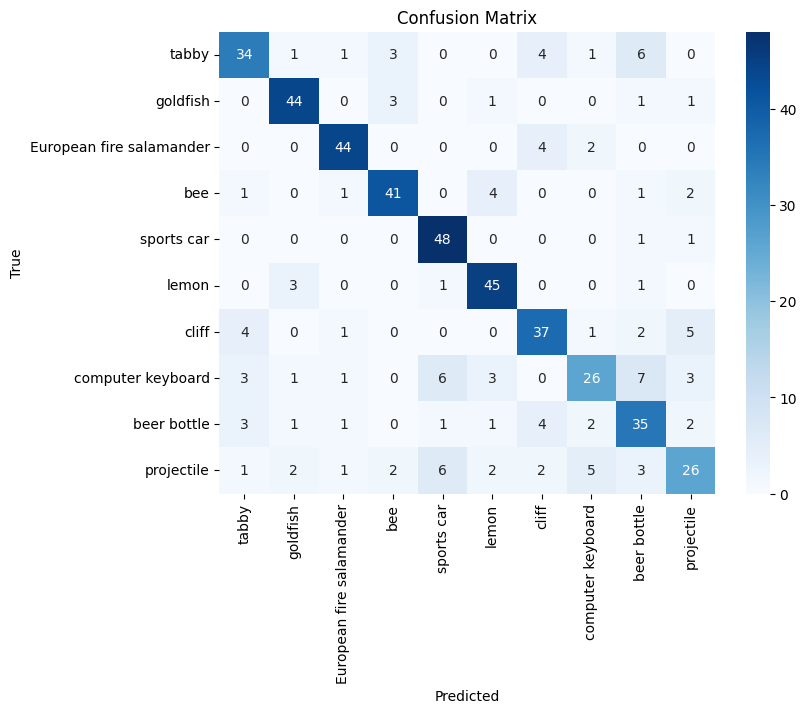

In [63]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_human,
            yticklabels=class_names_human)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 4.3: Визуальный анализ

In [64]:
indices = np.random.choice(len(test_subset_dataset), size=10, replace=False)

sample_images = []
sample_true_labels = []
sample_pred_labels = []

with torch.no_grad():
    for idx in indices:
        data, target = test_subset_dataset[idx]
        sample_images.append(data)
        sample_true_labels.append(target)

        predicted = model_final(data.unsqueeze(0).to(device))
        pred = torch.argmax(predicted, dim=1).item()
        sample_pred_labels.append(pred)

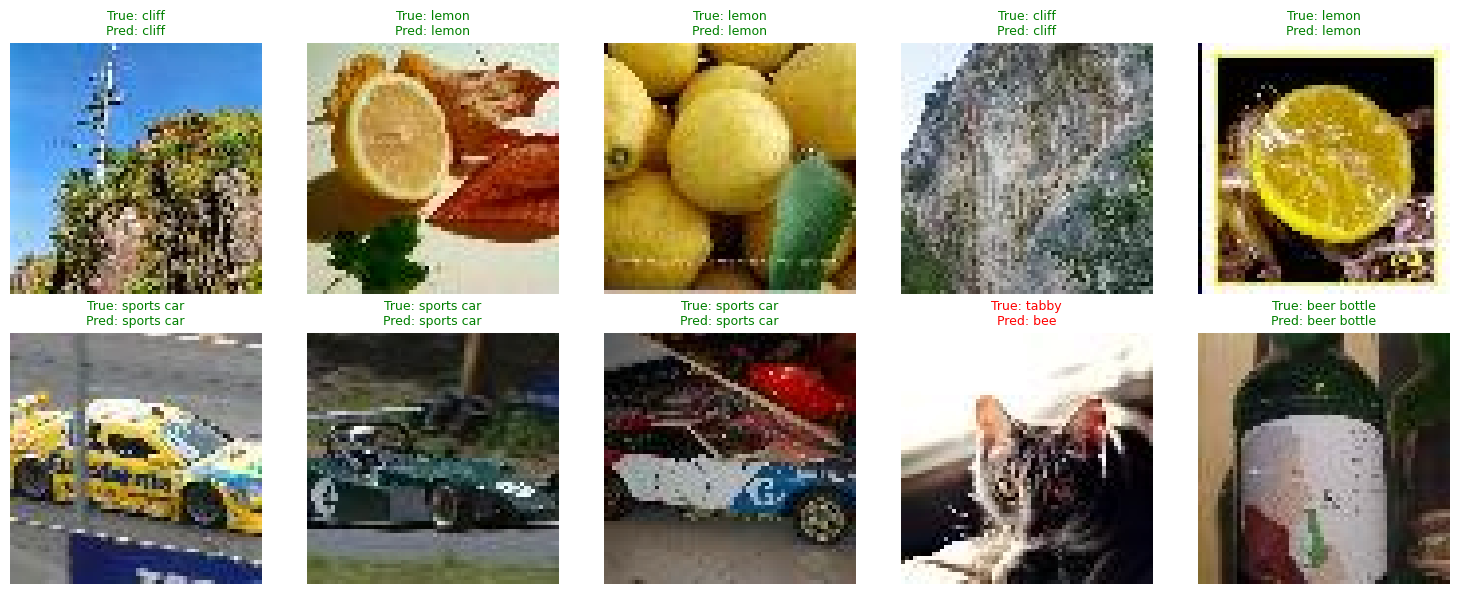

In [65]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

for i in range(10):
    ax = axes[i]
    img = sample_images[i]
    img = inv_normalize(img)
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0).numpy()

    ax.imshow(img)
    true_cls = sample_true_labels[i]
    pred_cls = sample_pred_labels[i]
    color = 'green' if true_cls == pred_cls else 'red'
    true_name = class_names_human[true_cls]
    pred_name = class_names_human[pred_cls]
    ax.set_title(f"True: {true_name}\nPred: {pred_name}", color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 4.4: Сравнительная таблица всех экспериментов

| Этап        | Конфигурация                          | Параметры   | Val Accuracy | Train Accuracy |
|-------------|---------------------------------------|-------------|--------------|----------------|
| Baseline    | BaseModel (ReLU, 4 блока, 200→256)    | 4.79M       | **76.88%**    | **88.16%**     |
| 3.1-A       | Каналы: 32→64→128→256                 | 2.79M       | **74.69%**        | **91.96%**        |
| 3.1-B       | Каналы: 64→128→256                    | 2.74M       | 72.71%    | 88.84%     |
| 3.2-A       | [1,1,1,1] блоков                        | 1.22M       | **75.31%**        | **99.47%**         |
| 3.2-B       | [2,2,2,2] блоков                        | 2.79M       | 74.69%    | 91.96%     |
| 3.2-C       | [3,3,3,3] блоков                        | 4.29M       | 72.50%             | 92.97%         |
| 3.3-A       | ReLU                                  | 1.22M       | 75.31%        | 99.47%         |
| 3.3-B       | LeakyReLU                             | 1.22M       | 74.17%    | 97.56%         |
| 3.3-C       | ELU                                   | 1.22M       | 71.15%    | 90.50%         |
| 3.3-D       | GELU                                  | 1.22M       | **76.88%**    | **99.72%**     |
| Final       | **GELU + [1,1,1,1] + 32→64→128→256** (40 эпох) | **1.22M**   | **77.92%**    | **100.00%**     |

**Вывод:** лучший результат показала модель с архитектурой GELU + [1,1,1,1] residual-блока + каналы  32→64→128→256, обученная 40 эпох, достигнув валидационной точности 77.92%.

Разница между тренировочной (100.00%) и валидационной (77.92%) точностью составляет около 22 процентных пунктов, что указывает на переобучение. Однако, все рассмотренные конфигурации модели переобучились. Таким образом для данной задачи более мелкая модель лучше.